# AKARI-SEP master catalogue
## Preparation of VHS data

VISTA telescope/VHS catalogue: the catalogue comes from `dmu0_VHS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band.
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "vhs_ra"
DEC_COL = "vhs_dec"

## I - Column selection

In [4]:
# Bands: Y,J,H,K
imported_columns = OrderedDict({
        'SOURCEID': "vhs_id",
        'ra': "vhs_ra",
        'dec': "vhs_dec",
        'PSTAR':  "vhs_stellarity",
        #'YPETROMAG': "m_vista_y",     #All Y fluxes empty on AKARI-SEP
        #'YPETROMAGERR': "merr_vista_y", 
        #'YAPERMAG3': "m_ap_vista_y", 
        #'YAPERMAG3ERR': "merr_ap_vista_y",
        'JPETROMAG': "m_vista_j", 
        'JPETROMAGERR': "merr_vista_j", 
        'JAPERMAG3': "m_ap_vista_j", 
        'JAPERMAG3ERR': "merr_ap_vista_j",        
        'HPETROMAG': "m_vista_h", 
        'HPETROMAGERR': "merr_vista_h", 
        'HAPERMAG3': "m_ap_vista_h", 
        'HAPERMAG3ERR': "merr_ap_vista_h",        
        'KSPETROMAG': "m_vista_k", 
        'KSPETROMAGERR': "merr_vista_k", 
        'KSAPERMAG3': "m_ap_vista_k", 
        'KSAPERMAG3ERR': "merr_ap_vista_k",
    })


catalogue = Table.read("../../dmu0/dmu0_VISTA-VHS/data/VHS_AKARI-SEP.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

In [5]:
# Conversion from Vega magnitudes to AB is done using values from 
# http://casu.ast.cam.ac.uk/surveys-projects/vista/technical/filter-set
vega_to_ab = {
    "z": 0.521,
    "y": 0.618,
    "j": 0.937,
    "h": 1.384,
    "k": 1.839
}

In [6]:
# Coverting from Vega to AB and adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # Some object have a magnitude to 0, we suppose this means missing value
        catalogue[col][catalogue[col] <= 0] = np.nan
        catalogue[errcol][catalogue[errcol] <= 0] = np.nan 
        
        # Convert magnitude from Vega to AB
        catalogue[col] += vega_to_ab[col[-1]]
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [7]:
catalogue[:10].show_in_notebook()

idx,vhs_id,vhs_ra,vhs_dec,vhs_stellarity,m_vista_j,merr_vista_j,m_ap_vista_j,merr_ap_vista_j,m_vista_h,merr_vista_h,m_ap_vista_h,merr_ap_vista_h,m_vista_k,merr_vista_k,m_ap_vista_k,merr_ap_vista_k,f_vista_j,ferr_vista_j,flag_vista_j,f_ap_vista_j,ferr_ap_vista_j,f_vista_h,ferr_vista_h,flag_vista_h,f_ap_vista_h,ferr_ap_vista_h,f_vista_k,ferr_vista_k,flag_vista_k,f_ap_vista_k,ferr_ap_vista_k
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,473215407757,69.806952647,-53.2948111937,0.9,21.3606,0.357663,21.0975,0.261915,nan,nan,nan,nan,nan,nan,nan,nan,10.3699,3.41605,False,13.2126,3.18732,nan,nan,False,nan,nan,nan,nan,False,nan,nan
1,473215410968,69.8989119787,-53.4675018487,0.05,20.2597,0.1653,20.9093,0.237073,nan,nan,nan,nan,nan,nan,nan,nan,28.5842,4.35184,False,15.7131,3.43099,nan,nan,False,nan,nan,nan,nan,False,nan,nan
2,473215405777,69.8767007631,-53.1909827086,0.9,21.167,0.308411,20.5301,0.168175,nan,nan,nan,nan,nan,nan,nan,nan,12.3931,3.52035,False,22.2815,3.4513,nan,nan,False,nan,nan,nan,nan,False,nan,nan
3,473215415721,69.8310028706,-53.7137715926,0.05,20.7059,0.193077,20.4594,0.147989,nan,nan,nan,nan,nan,nan,nan,nan,18.9521,3.37027,False,23.7814,3.24148,nan,nan,False,nan,nan,nan,nan,False,nan,nan
4,473215411342,69.8717086782,-53.4884701194,0.05,20.6914,0.191685,20.5063,0.161906,nan,nan,nan,nan,nan,nan,nan,nan,19.2061,3.3908,False,22.7758,3.39634,nan,nan,False,nan,nan,nan,nan,False,nan,nan
5,473215411433,69.8619655263,-53.4937760407,0.05,21.8182,0.54841,20.5138,0.159067,nan,nan,nan,nan,nan,nan,nan,nan,6.80327,3.43636,False,22.6195,3.31389,nan,nan,False,nan,nan,nan,nan,False,nan,nan
6,473215416091,69.8673184652,-53.7326573599,0.9,20.9207,0.303069,20.9697,0.240281,nan,nan,nan,nan,nan,nan,nan,nan,15.5501,4.34061,False,14.863,3.28929,nan,nan,False,nan,nan,nan,nan,False,nan,nan
7,473215411687,69.8027676351,-53.5085961774,0.05,20.8475,0.25367,20.6834,0.185638,nan,nan,nan,nan,nan,nan,nan,nan,16.6342,3.8864,False,19.3474,3.308,nan,nan,False,nan,nan,nan,nan,False,nan,nan
8,473215411719,69.90305388,-53.5108991527,0.9,21.7087,0.625264,20.9669,0.249831,nan,nan,nan,nan,nan,nan,nan,nan,7.52516,4.33366,False,14.9013,3.42884,nan,nan,False,nan,nan,nan,nan,False,nan,nan


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:
SORT_COLS = ['merr_ap_vista_h', 'merr_ap_vista_j', 'merr_ap_vista_k']
FLAG_NAME = 'vhs_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 160013 sources.
The cleaned catalogue has 159999 sources (14 removed).
The cleaned catalogue has 14 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_AKARI-SEP.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

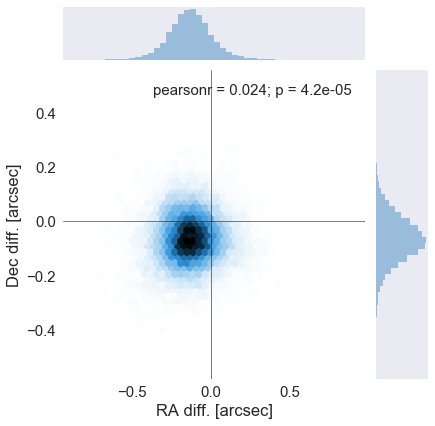

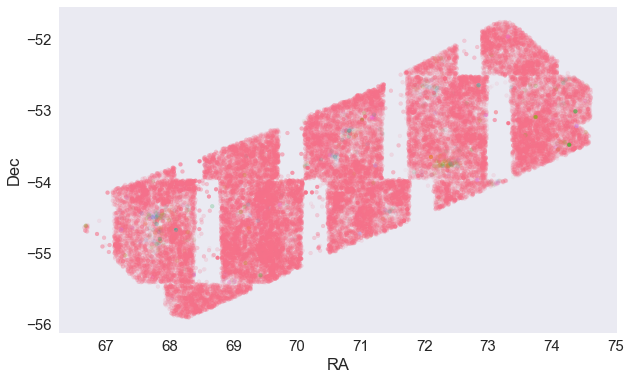

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.13254794655779278 arcsec
Dec correction: 0.06519666017936743 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

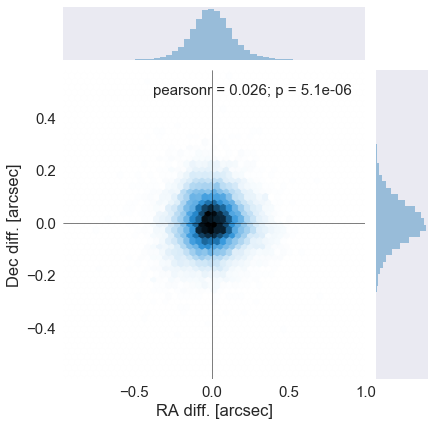

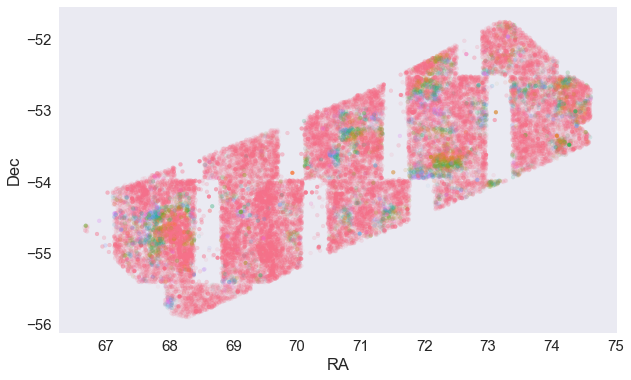

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "vhs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

30228 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/VISTA-VHS.fits".format(OUT_DIR), overwrite=True)